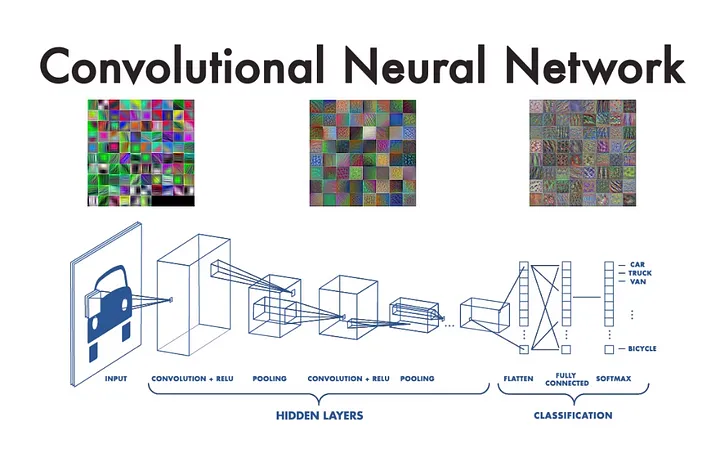

A CNN, or Convolutional Neural Network, is a type of deep learning model designed specifically for processing structured grid data, such as images and videos. CNNs have proven to be highly effective in various computer vision tasks, including image classification, object detection, facial recognition, and more.

Key characteristics of CNNs include:

1. Convolutional Layers: CNNs use convolutional layers to apply filters (kernels) to small regions of the input data. These filters are responsible for detecting features like edges, textures, and shapes within the image. Convolutional operations are used to scan the entire input, and they capture hierarchical patterns in the data.

2. Pooling Layers: Pooling layers (e.g., max pooling or average pooling) are used to downsample the spatial dimensions of the data while retaining the most important information. Pooling helps reduce the computational complexity of the network and makes the model more robust to variations in input scale and position.

3. Fully Connected Layers: After multiple convolutional and pooling layers, CNNs often use one or more fully connected layers to make final predictions or classifications. These layers process the extracted features from earlier layers and produce the network's output.

4. Hierarchical Feature Learning: CNNs learn hierarchical representations of features. Lower layers capture low-level features like edges and textures, while higher layers combine these features to recognize more complex patterns and objects.

5. Weight Sharing: CNNs use weight sharing to reuse learned patterns across different parts of the input data. This sharing of weights reduces the number of parameters in the network, making it computationally efficient.

6. Convolutional Filters: Convolutional layers employ learnable filters to automatically learn and adapt to features present in the data. These filters are updated during training through backpropagation.

7. Activation Functions: Activation functions like ReLU (Rectified Linear Unit) introduce non-linearity into the network, allowing it to model complex relationships in the data.

CNNs have revolutionized the field of computer vision and have been instrumental in achieving state-of-the-art results in various image-related tasks. They are widely used in applications such as image recognition, medical image analysis, autonomous vehicles, and more.

## INTRODUCTION-Problem Statement

in this exercise, we have about 6000 of pediatric lung x rays where we will try to train a CNN model to classify if the child has pneumonia or not. We will implement two different transfer learning techniques to train and evaluate our model. 

Transfer learning in Convolutional Neural Networks (CNNs) is a machine learning technique that leverages pre-trained models on one task (usually a large dataset) and adapts them to perform a different but related task. Instead of training a CNN from scratch on a new dataset, transfer learning allows you to start with a model that has already learned useful features from a source task and fine-tune it for the target task. This can significantly reduce the amount of labeled data and training time required for the target task.

The main steps in transfer learning with CNNs are as follows:

1. **Pre-trained Model**: Start with a pre-trained CNN model that has been trained on a large-scale dataset, often for a generic computer vision task like image classification. Common pre-trained models include VGG, ResNet, Inception, and MobileNet, among others.

2. **Feature Extraction**: Use the pre-trained model as a fixed feature extractor. Remove the final classification layer(s) of the model, leaving only the feature extraction layers. These layers capture hierarchical representations of features and are transferable to other tasks.

3. **Custom Head**: Add a new set of fully connected layers (the head) to the model. This head will be specific to your target task and is responsible for making predictions. The architecture of the custom head depends on the specific task, such as image classification, object detection, or segmentation.

4. **Fine-Tuning**: Train the entire model (feature extraction layers + custom head) on your target dataset with labeled examples. During this phase, both the feature extraction layers and the custom head are updated using backpropagation. You can choose to freeze some layers (i.e., keep their weights fixed) if you have limited training data.

Transfer learning offers several advantages:

- **Faster Training**: Transfer learning reduces training time because you start with a model that has already learned useful representations, so convergence is faster.

- **Better Performance**: By leveraging knowledge from a related task, transfer learning often leads to better performance on the target task, especially when you have limited data.

- **Reduced Data Requirements**: You can achieve good results with smaller datasets, which is particularly useful when labeled data is scarce.

Transfer learning is widely used in computer vision for a wide range of applications, including image classification, object detection, image segmentation, and more. It allows practitioners to harness the power of large-scale pre-trained models and adapt them to solve specific problems efficiently.We will be using teh Resnet pretrained model for our task and apply two different techniques to evaluate our model. 

1) Transfer Learning by FineTuning the pretrained Resnet101 Model.

2) Transfer Learning with pretrained Resnet101 model as fixed feature extractor.

Differences between Fine Tuning and Feature Extraction

Fine-tuning and feature extraction are two common techniques used in transfer learning with Convolutional Neural Networks (CNNs). They have different purposes and are applied at different stages of the transfer learning process. Here are the key differences between fine-tuning and feature extraction:

1. **Purpose**:

   - **Fine-Tuning**: Fine-tuning involves taking a pre-trained model and updating its weights (parameters) on a new dataset, typically for a related task. The goal is to adapt the model's learned representations to perform well on the target task. Fine-tuning allows the model to adjust its internal representations while retaining some knowledge from the source task.

   - **Feature Extraction**: Feature extraction, on the other hand, uses a pre-trained model as a fixed feature extractor. It removes the top layers responsible for making predictions and only retains the feature extraction layers. Feature extraction is mainly used to extract useful features from input data, which are then fed into a custom head (classifier or regressor) for the target task.

2. **Layers Modified**:

   - **Fine-Tuning**: In fine-tuning, both the feature extraction layers and the custom head (output layers) are updated during training. The entire model is trained on the target task, and backpropagation is used to adjust the weights of all layers. Some layers may be frozen (weights are not updated) if there is limited data, and they are believed to capture generic features.

   - **Feature Extraction**: In feature extraction, only the custom head (output layers) is added and trained. The pre-trained model's feature extraction layers are kept frozen, meaning their weights remain unchanged throughout training. These layers are treated as fixed feature extractors.

In summary, fine-tuning involves updating the entire model with a new dataset, while feature extraction uses a pre-trained model's fixed feature extraction layers to extract relevant features for a specific task. The choice between these techniques depends on the amount of data available, the similarity between tasks, and the computational resources at hand.

## Importing necessary libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image  # Import PIL to resize images

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Below code sets up a pipeline for transforming input images in a way that prepares them for consumption by a CNN model. It's a standard practice in computer vision tasks to ensure that the data is appropriately preprocessed before training or testing deep learning models. It allows the model to generalize better and make better predictions.

transforms.RandomResizedCrop(224): Randomly crops and resizes the input image to a size of 224x224 pixels. This helps the model learn to recognize objects or features at different scales and positions within the image.

transforms.RandomHorizontalFlip(): Randomly flips the image horizontally with a 50% probability. This creates mirror images and helps the model learn to recognize objects from different orientations.

transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): This line applies pixel-wise mean subtraction and standard deviation scaling to the image. 

## Data Preprocessing

In [2]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Importing the data and checking the class labels and sizes of train and test folders.

In [3]:
#Data path
data_dir = "/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia"
#Load data
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['train', 'test']}
              
#Define Train and Validation Dataloaders
dataloaders = {x: torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}

dataset_sizes = {x: len(Datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = Datasets['train'].classes
print(class_names)

{'train': 5232, 'test': 624}
['NORMAL', 'PNEUMONIA']


## Data Analysis and basic visualizations

Looking at the label counts for train and test data for any imbalance concerns. For example, if we have a lot less pneumonia x rays than normal x rays, our model may have a hard time training and predicting that category compared to the Normal cases. We see that is not a concerns here sonce we have enough examples of both categories.

In [4]:
# Initialize counters for train and test sets
train_label_counts = {class_name: 0 for class_name in class_names}
test_label_counts = {class_name: 0 for class_name in class_names}

# Iterate through the train dataset to count labels
for inputs, labels in dataloaders['train']:
    for label in labels.tolist():
        class_name = class_names[label]
        train_label_counts[class_name] += 1

# Iterate through the test dataset to count labels
for inputs, labels in dataloaders['test']:
    for label in labels.tolist():
        class_name = class_names[label]
        test_label_counts[class_name] += 1

# Print the label counts for train and test sets
print("Train Label Counts:")
for class_name, count in train_label_counts.items():
    print(f"{class_name}: {count}")

print("\nTest Label Counts:")
for class_name, count in test_label_counts.items():
    print(f"{class_name}: {count}")


Train Label Counts:
NORMAL: 1349
PNEUMONIA: 3883

Test Label Counts:
NORMAL: 234
PNEUMONIA: 390


Randomly looking at 5 x-rays from each class. The differences are noticable to the human eye.

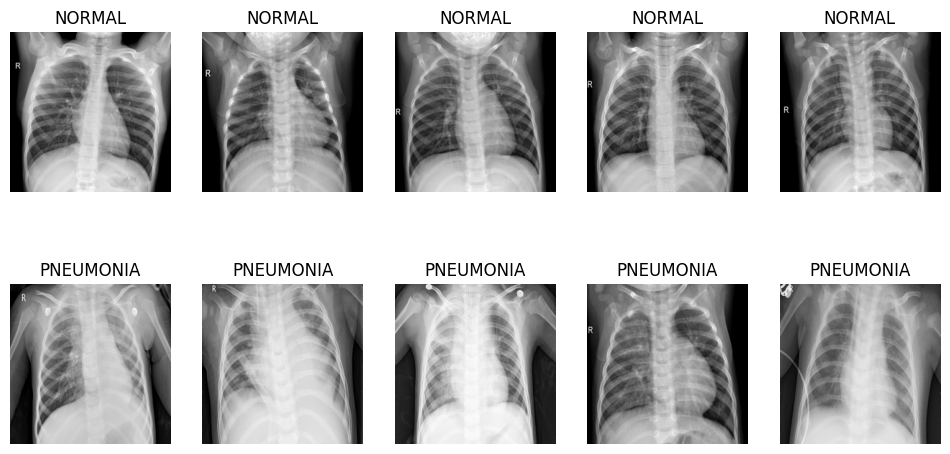

In [5]:
train_path = "../input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train"
test_path = "../input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test"

normal_images = [img for img in os.listdir(f'{train_path}/NORMAL')]
pneumonia_images = [img for img in os.listdir(f'{train_path}/PNEUMONIA')]

# Randomly select a few images from the set to view
normal_select = np.random.choice(normal_images, 5, replace=False)
pneumonia_select = np.random.choice(pneumonia_images, 5, replace=False)

# Define a common size for all images
common_size = (224, 224)

# Plot the selected images with equal sizes
fig = plt.figure(figsize=(12, 6))


for i in range(10):
    if i < 5:
        fpath = f'{train_path}/NORMAL/{normal_select[i]}'
        label = 'NORMAL'
    else:
        fpath = f'{train_path}/PNEUMONIA/{pneumonia_select[i-5]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 5, i+1)
    
    # Open the image using PIL and resize it to the common size
    im = Image.open(fpath)
    im = im.resize(common_size)
    
    plt.imshow(im, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()


Setting up GPUs and training function

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import time
import copy

## Training function

Training with early stop to avoid unnecessary processing. if the loss function does not improve for 2 consecutive epochs(patience=2), we will stop training.

In [8]:
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, num_epochs=100, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    consecutive_epochs_without_improvement = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'test':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Usage
#best_model = train_model_with_early_stopping(model, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=100, patience=2)


Functions to display images after evauluation is complete

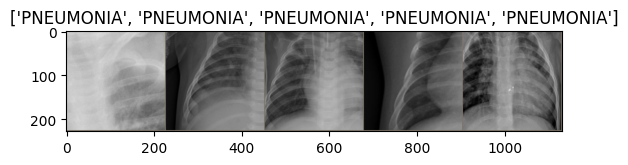

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def visualize_model(model, num_images=15):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            percentage = torch.sigmoid(outputs)[0] * 100 
            _, indices = torch.sort(outputs, descending=True)
            probs=[percentage[idx].item() for idx in indices[0][:4]]

            classes=[class_names[idx] for idx in indices[0][:4]]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 5, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Initializing the resnet model

We will be using one of the variations of the resnet model which is one of the most commonly used pre trained CNN models for image classification and object detection tasks.

In [11]:
import torchvision
from torchvision import models
import torch.nn as nn

## Transfer learning by fine tuning

Fine tuning will allow to adjust the weights of our network by making forward and backward passes(backpropogation) to find optimized values.

Backpropagation, short for "backward propagation of errors," is a fundamental algorithm used in the training of artificial neural networks, including deep learning models like neural networks and convolutional neural networks (CNNs). It is the primary mechanism through which neural networks learn from data and adjust their internal parameters (weights and biases) to minimize the error or loss between their predictions and the actual target values.

You can also see all the layers of our network in the output. 

In [12]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)

print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 246MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
import torch.optim as optim
from torch.optim import lr_scheduler

Optimization and defining hyperparameters:

lr=0.00001 sets the learning rate, which controls the step size of parameter updates during optimization. A smaller learning rate often results in slower but more stable training.

The learning rate scheduler adjusts the learning rate during training, potentially improving the convergence of the optimization process.lr_scheduler.StepLR creates a learning rate scheduler that decreases the learning rate by a factor of 0.1 every 7 epochs. This can be useful for gradually reducing the learning rate as training progresses.

The loss function, often referred to as the criterion, measures the error or mismatch between the model's predictions and the actual target values (labels) for the training data.
nn.CrossEntropyLoss() sets up a common loss function used for classification tasks, where the goal is to predict one of several class labels. It combines a softmax activation function with the negative log-likelihood loss.

In [14]:
#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

##  Model Training and evaluation with early stop

In [15]:
model_fineTuning = train_model_with_early_stopping(Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=10)
torch.save(model_fineTuning, "/kaggle/working/Resnet_fineTuning.pth")


Epoch 0/9
----------
train Loss: 0.3063 Acc: 0.8760
test Loss: 0.3082 Acc: 0.9151

Epoch 1/9
----------
train Loss: 0.2088 Acc: 0.9211
test Loss: 0.2791 Acc: 0.9231

Epoch 2/9
----------
train Loss: 0.1872 Acc: 0.9312
test Loss: 0.2001 Acc: 0.9375

Epoch 3/9
----------
train Loss: 0.1695 Acc: 0.9346
test Loss: 0.2054 Acc: 0.9391

Epoch 4/9
----------
train Loss: 0.1616 Acc: 0.9413
test Loss: 0.1715 Acc: 0.9439

Epoch 5/9
----------
train Loss: 0.1446 Acc: 0.9467
test Loss: 0.1887 Acc: 0.9407

Epoch 6/9
----------
train Loss: 0.1469 Acc: 0.9478
test Loss: 0.1932 Acc: 0.9343
Early stopping after 6 epochs
Training complete in 20m 0s
Best val Acc: 0.9439


Model accuracy is at 94% using test data. This is very good.

Saving the model

In [16]:
Resnet_fineTuning = torch.load('/kaggle/working/Resnet_fineTuning.pth')

Visualizing the predictions

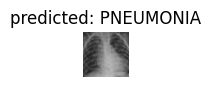

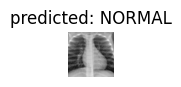

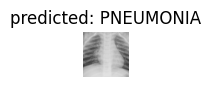

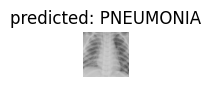

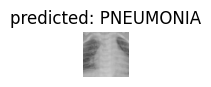

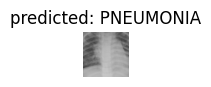

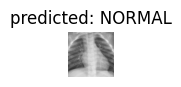

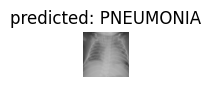

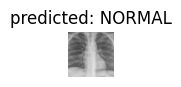

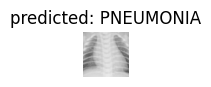

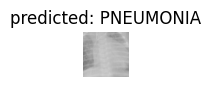

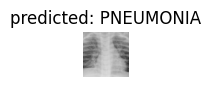

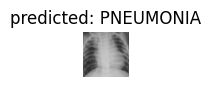

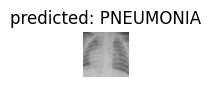

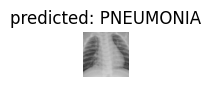

In [17]:
visualize_model(Resnet_fineTuning)

## Transfer Learning with pretrained Resnet101 model as fixed feature extractor

Only last layer will be replaced so we need to keep all the network layer weights stable and unchanged. In order to achieve this, we set param.requires_grad = False.

In [18]:
#Load Resnet101 pretained Model
Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
#Resnet101 = models.resnet101(weights=True)

#Here, we freeze all the network weights except the final layer. 
#We need to set requires_grad = False to freeze the parameters 
#so that the gradients are not computed in backward().
for param in Resnet101.parameters():
    param.requires_grad = False

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Replace the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

#Only last replaced layer will be trained and 
#the rest of the network is treated as a fixed feature extractor.
Resnet_featureExtractor = Resnet101.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


SGD stands for Stochastic Gradient Descent, which is a widely used optimization algorithm in machine learning and deep learning. It's a variant of gradient descent, a technique for minimizing a loss function to train a machine learning model.

In [19]:
#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(Resnet_featureExtractor.fc.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model_featureExtractor = train_model_with_early_stopping(Resnet_featureExtractor, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=10)
torch.save(model_featureExtractor, "/kaggle/working/Resnet_featureExtractor.pth")

Epoch 0/9
----------
train Loss: 0.6069 Acc: 0.7229
test Loss: 0.7005 Acc: 0.6250

Epoch 1/9
----------
train Loss: 0.5745 Acc: 0.7422
test Loss: 0.6863 Acc: 0.6250

Epoch 2/9
----------
train Loss: 0.5610 Acc: 0.7422
test Loss: 0.6768 Acc: 0.6250
Early stopping after 2 epochs
Training complete in 5m 57s
Best val Acc: 0.6250


In [21]:
Resnet_featureExtractor = torch.load('/kaggle/working/Resnet_featureExtractor.pth')

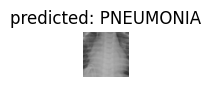

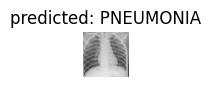

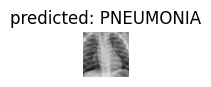

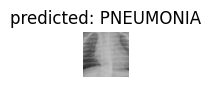

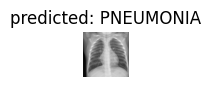

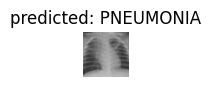

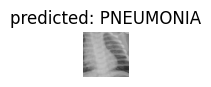

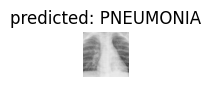

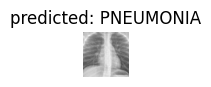

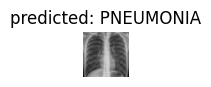

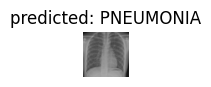

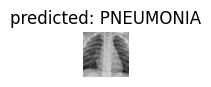

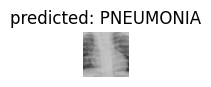

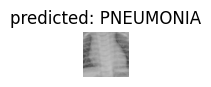

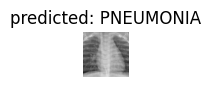

In [22]:
visualize_model(Resnet_featureExtractor)

## CONCLUSION

We see that transfer learning with fine tuning provides much better results compared to transfer learning with feature extraction.94% vs 62%. This is mainly because fine tuning offers better acuracy since the weights of all network layers are adjusted as opposed to only adjusting the last connected layer during feature extraction. However, if you prefer to save time from training and you dont have much data, you may prefer feature extraction.